# Machine Learning for Single-Cell Biology
***

Winter Semester 2024/25<br />
Manfred Claassen, Matthias Bruhns, Jan Schleicher
<br />
***

## Assignment 1

In [15]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
from functools import reduce

import os
from utils import import_mtx_expression_data
from typing import Tuple

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("ticks")

%matplotlib inline

In [16]:
DATA_PATH = "data/"
OUTPUT_PATH = "output/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

### Task 1

In [17]:
# Load the data
expression_data_1 = import_mtx_expression_data(os.path.join(DATA_PATH, "expression_data_1.mtx"),
                                               os.path.join(DATA_PATH, "expression_data_1_barcodes.tsv"),
                                               os.path.join(DATA_PATH, "expression_data_1_genes.tsv"))
metadata_1 = pd.read_csv(os.path.join(DATA_PATH, "expression_data_1_metadata.tsv"), sep="\t", index_col=0)
metadata_1.columns = ["CellType", "Organ"]

First, we identified the organ of origin by using cell type proportions in each organ. For this, we tried to replicate the figure 2J from the paper.

In [24]:
def task1a_identification(expression_data: pd.DataFrame, metadata: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Analyze the data to identify cell types and organs
    :param expression_data: expression matrix of shape (n_cells, n_genes)
    :param metadata: metadata containing cell groupings and sample IDs
    :return: organ and cell type identities
    """
    organ_identity = {"A": "spleen", "B": "LN", "C": "BM", "D": "blood", "E": "liver", "F": "lung"}
    cell_type_identity = {"T1": "E", "T2": "Exh", "T3": "I", "T4": "M", "T5": "P"}

    return pd.DataFrame.from_dict(organ_identity, orient="index"), \
        pd.DataFrame.from_dict(cell_type_identity, orient="index")

In [25]:
def cell_type_frequency(metadata):
    """
    Calculate the frequency of all cell types in each organ.
    :param metadata: annotation data containing CellType and Organ annotations.
    :return: frequency of all cell types in each organ as a DataFrame
    """
    frequency = []
    for organ in metadata.Organ.unique():
        cells = (metadata[metadata.Organ == organ]).groupby("CellType").count()
        cellCounts = cells.Organ.tolist()
        cellFrequencies = np.array(cellCounts) / sum(cellCounts)

        frequency.append(pd.DataFrame({
            "CellType": cells.index,
            organ: cellFrequencies
        }))

    frequency = reduce(lambda left, right: pd.merge(left, right, on = "CellType"), frequency)

    frequency = frequency.T
    frequency.columns = frequency.iloc[0, :].tolist()
    frequency = frequency.iloc[1:, :]

    frequency["Organ"] = frequency.index

    return frequency

In [32]:
# Identified organ and cell identities
organ_identity, cell_type_identity = task1a_identification(expression_data_1, metadata_1)
organ_identity = organ_identity.to_dict().get(0)
cell_type_identity = cell_type_identity.to_dict().get(0)

In [33]:
# Count the frequency of all cell types in each organ
frequency = cell_type_frequency(metadata_1)

# Set the correct order of the cell types
frequency = frequency[["Organ", "T5", "T4", "T3", "T2", "T1"]]

# Add identified organ and cell type annotations to the data
frequency.index = [f"{organ}: {organ_identity.get(organ)}" for organ in frequency.index]
frequency.columns = ["Organ"] + [f"{cellType}: {cell_type_identity.get(cellType)}" for cellType in frequency.columns[1:]]

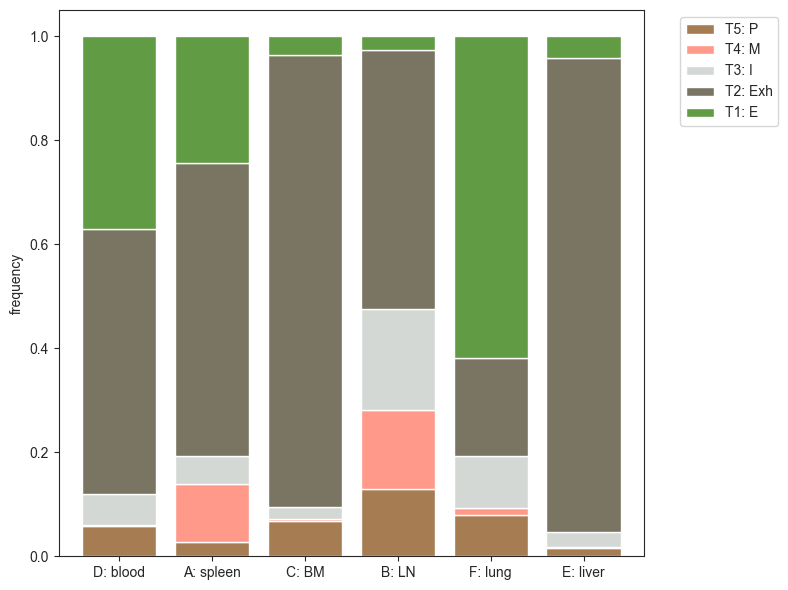

In [34]:
fig, ax = plt.subplots(figsize = (8, 6))
colors = ["#a67c52", "#ff9a8b", "#d4d8d5", "#7a7563", "#619b44"]
frequency.set_index("Organ").plot(kind = "bar", stacked = True, color = colors, ax = ax, width = 0.8)
ax.set_ylabel("frequency")
ax.set_xlabel("")
ax.set_xticklabels(frequency.index, rotation = 0)
ax.legend(title = "", bbox_to_anchor = (1.05, 1), loc = "upper left", labels = frequency.columns[1:])
plt.tight_layout()
plt.show()

In [35]:
task1a_organ_identity, task1a_cell_type_identity = task1a_identification(expression_data_1, metadata_1)

task1a_organ_identity.to_csv(os.path.join(OUTPUT_PATH, "task1a_organ_identity.txt"), sep="\t", header=False)
task1a_cell_type_identity.to_csv(os.path.join(OUTPUT_PATH, "task1a_cell_type_identity.txt"), sep="\t", header=False)

display(task1a_organ_identity)
display(task1a_cell_type_identity)

,0
A,spleen
B,LN
C,BM
D,blood
E,liver
F,lung


,0
T1,E
T2,Exh
T3,I
T4,M
T5,P


In [ ]:
# Load the data
expression_data_2 = import_mtx_expression_data(os.path.join(DATA_PATH, "expression_data_2.mtx"),
                                               os.path.join(DATA_PATH, "expression_data_2_barcodes.tsv"),
                                               os.path.join(DATA_PATH, "expression_data_2_genes.tsv"))

# If required, perform preprocessing of the data
#########################
# INSERT YOUR CODE HERE #
#########################

In [ ]:
def task1b_annotation(expression_data: pd.DataFrame, expression_data_ref: pd.DataFrame, metadata_ref) -> pd.DataFrame:
    """
    Annotate each cell with its corresponding cell type
    :param expression_data: expression matrix of shape (n_cells, n_genes)
    :param expression_data_ref: reference expression matrix of shape (n_cells_ref, n_genes)
    :param metadata_ref: reference metadata with n_cells_ref rows and a column containing true cell types for expression_data_ref
    :return: cell type annotations for expression_data
    """
    cell_annotations = pd.DataFrame(index=expression_data.index.values, columns=["phenotype"])

    #########################
    # INSERT YOUR CODE HERE #
    #########################

    return cell_annotations

**Please also submit the output CSV file with the annotations for Task 1b!**

In [ ]:
task1b_cell_annotations = task1b_annotation(expression_data_2, expression_data_1, metadata_1)
task1b_cell_annotations.to_csv(os.path.join(OUTPUT_PATH, "task1b_cell_annotations.txt"), sep="\t")

### Task 2

In [ ]:
cell_sequences = np.load(os.path.join(DATA_PATH, "tex_sampling.npy"))
metadata_3 = pd.read_csv(os.path.join(DATA_PATH, "expression_data_3_metadata.txt"), sep="\t", index_col=0)
expression_data_3 = import_mtx_expression_data(os.path.join(DATA_PATH, "expression_data_3.mtx"),
                                               os.path.join(DATA_PATH, "expression_data_3_barcodes.tsv"),
                                               os.path.join(DATA_PATH, "expression_data_3_genes.tsv"))

In [ ]:
def task2a_trajectory_analysis(sequences: np.ndarray, metadata: pd.DataFrame) -> Tuple[list, list]:
    """
    Identify an ordering of louvain clusters along the two trajectories
    :param sequences: numpy array of cell sequences (cell indices, corresponding to rows of metadata) of shape
    (n_sequences, n_steps)
    :param metadata: cell metadata with louvain clusters
    :return: orderings of louvain clusters along the two trajectories
    """
    upper_trajectory_louvain_ordering = []
    lower_trajectory_louvain_ordering = []

    #########################
    # INSERT YOUR CODE HERE #
    #########################

    return upper_trajectory_louvain_ordering, lower_trajectory_louvain_ordering

**Please also submit the output files with the cluster orderings for Task 2a!**

In [ ]:
task2a_upper_trajectory, task2a_lower_trajectory = task2a_trajectory_analysis(cell_sequences, metadata_3)
pd.DataFrame(task2a_upper_trajectory).to_csv(os.path.join(OUTPUT_PATH, "task2a_upper_trajectory.txt"), header=False)
pd.DataFrame(task2a_lower_trajectory).to_csv(os.path.join(OUTPUT_PATH, "task2a_lower_trajectory.txt"), header=False)

In [ ]:
def task2b_correlation_analysis(expression_data: pd.DataFrame, metadata: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the correlation of each gene's expression with sample ID
    :param expression_data: expression matrix of shape (n_cells, n_genes)
    :param metadata: metadata containing sample IDs (column name sampleID)
    :return: data frame with correlation and p value for each gene
    """
    gene_correlations = pd.DataFrame(data=np.ones((expression_data.shape[1], 3)), index=expression_data.columns.values,
                                     columns=["correlation", "abs_correlation", "p_value"])

    #########################
    # INSERT YOUR CODE HERE #
    #########################

    return gene_correlations

**Please also submit the output CSV file with the correlations for Task 2b!**

In [ ]:
task2b_gene_correlations = task2b_correlation_analysis(expression_data_3, metadata_3)
task2b_gene_correlations.sort_values("abs_correlation", ascending=False).iloc[:10]\
    .to_csv(os.path.join(OUTPUT_PATH, "task2b_gene_correlations.txt"), sep="\t")

fig, ax = plt.subplots(figsize=(9, 6))
sns.scatterplot(x=task2b_gene_correlations["correlation"], y=-np.log(task2b_gene_correlations["p_value"] + 1e-15), ax=ax)
ax.set_ylabel("-log p-value");